In [1]:
import tensorflow as tf
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load and prepare data

In [2]:
from PIL import Image
import numpy as np
from keras.preprocessing.image import img_to_array
from tensorflow.image import resize
import tensorflow as tf
import shutil
import os


imsize = (96,128) # (128,96)

x1_train = []
for archivo in os.listdir('dataset_sunrgbd/train_rgb'):
    img = Image.open(os.path.join('dataset_sunrgbd/train_rgb',archivo))
    img = resize(img_to_array(img), imsize)
    x1_train.append(np.asarray(img))
for archivo in os.listdir('dataset_sunrgbd/test_rgb'):
    img = Image.open(os.path.join('dataset_sunrgbd/test_rgb',archivo))
    img = resize(img_to_array(img), imsize)
    x1_train.append(np.asarray(img))
x1_train = np.array(x1_train)
x1_train = x1_train/255.0
print(x1_train.shape)


y_train = []
for archivo in os.listdir('dataset_sunrgbd/train_label'):
    img = np.load(os.path.join('dataset_sunrgbd/train_label',archivo))
    img[img == 20] = 2
    img[img == 3] = 0
    img[img == 31] = 3
    img[img > 3] = 0
    img = resize(img_to_array(img), imsize)
    y_train.append(img)
    
for archivo in os.listdir('dataset_sunrgbd/test_label'):
    img = np.load(os.path.join('dataset_sunrgbd/test_label',archivo))
    img[img == 20] = 2
    img[img == 3] = 0
    img[img == 31] = 3
    img[img > 3] = 0
    img = resize(img_to_array(img), imsize)
    y_train.append(img)
y_train = np.array(y_train).astype('uint8')
y_train = tf.keras.utils.to_categorical(y_train, dtype='float32')
print(y_train.shape)

del img

KeyboardInterrupt: 

In [3]:
x1_val = x1_train[6735:8335]
x1_test = x1_train[8335:10335]
x2_val = x2_train[6735:8335]
x2_test = x2_train[8335:10335]

y_val = y_train[6735:8335]
y_test = y_train[8335:10335]

x1_train = x1_train[:6735]
x2_train = x2_train[:6735]
y_train = y_train[:6735]

In [4]:
print(x1_train.shape, x2_train.shape, y_train.shape)
print(x1_val.shape, x2_val.shape, y_val.shape)
print(x1_test.shape, x2_test.shape, y_test.shape)

(6735, 128, 96, 3) (6735, 128, 96, 3) (6735, 128, 96, 4)
(1600, 128, 96, 3) (1600, 128, 96, 3) (1600, 128, 96, 4)
(2000, 128, 96, 3) (2000, 128, 96, 3) (2000, 128, 96, 4)


In [5]:
import matplotlib.pyplot as plt

def plot_color(ax, color, title="Color"):
    """Displays a color image from the NYU dataset."""

    ax.axis('off')
    ax.set_title(title)
    ax.imshow(color)

def plot_depth(ax, depth, title="Depth"):
    """Displays a depth map from the NYU dataset."""

    ax.axis('off')
    ax.set_title(title)
    ax.imshow(depth, cmap='Spectral')

def plot_label(ax, labels, title="Label"):
    """Displays a label map from the NYU dataset."""

    ax.axis('off')
    ax.set_title(title)
    ax.imshow(labels)

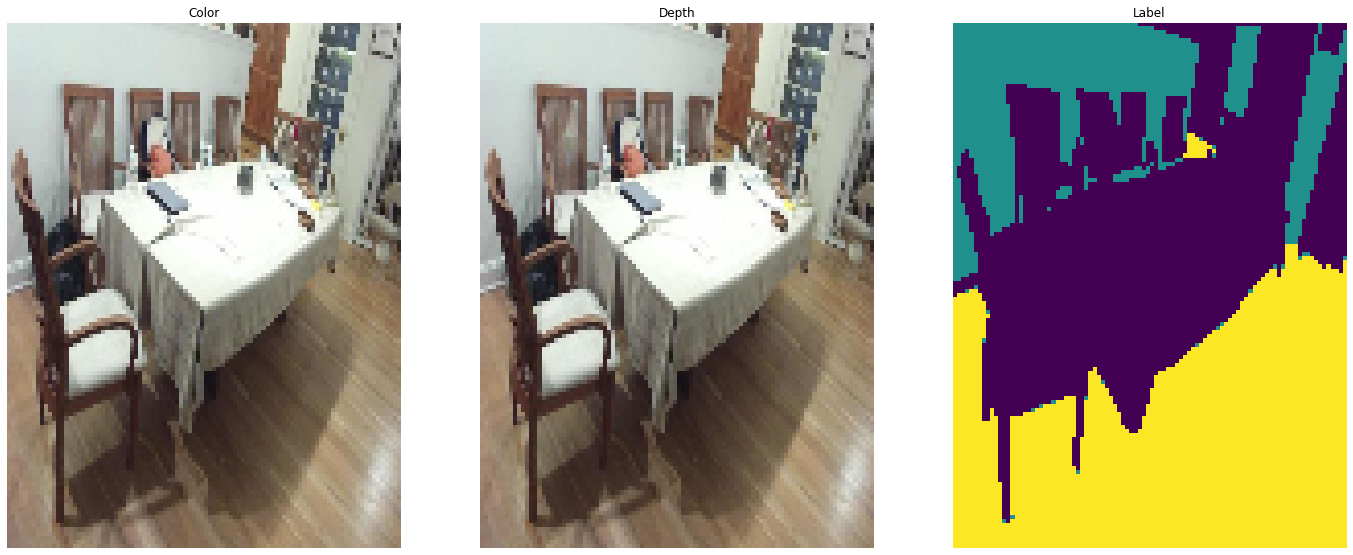

In [6]:
fig = plt.figure("Labeled Dataset Sample", figsize=(24, 10))

for number in range(1):
    fig = plt.figure("Labeled Dataset Sample", figsize=(24, 10))
    ax = fig.add_subplot(1, 3, 1)
    plot_color(ax, x1_train[number])

    ax = fig.add_subplot(1, 3, 2)
    plot_depth(ax, x2_train[number])

    ax = fig.add_subplot(1, 3, 3)
    plot_label(ax, np.argmax(y_train[number],axis=-1))

    plt.show()

In [7]:
from segmentation_models import get_preprocessing

BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)


x1_train = preprocess_input(x1_train)
x2_train = preprocess_input(x2_train)
x1_val = preprocess_input(x1_val)
x2_val = preprocess_input(x2_val)
x1_test = preprocess_input(x1_test)
x2_test = preprocess_input(x2_test)

Segmentation Models: using `keras` framework.


In [8]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rotation_range=15,
        shear_range=0.02,
        zoom_range=[0.9, 1.25],
        width_shift_range=0.1,
        height_shift_range=0.1,
        fill_mode="reflect") #'nearest'
val_datagen = ImageDataGenerator()

In [9]:
train_datagen.fit(x1_train)
val_datagen.fit(x1_val)

In [10]:
train = train_datagen.flow([x1_train, x2_train], y_train, batch_size=8)
validation = val_datagen.flow([x1_val, x2_val], y_val, batch_size=8)

# Create model

In [11]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable
import segmentation_models as sm


sm.set_framework('tf.keras')
sm.framework()

pretrained_model_1 = Unet(backbone_name='resnet34', encoder_weights='imagenet', encoder_freeze=True, classes=30, activation='softmax', input_shape=(None, None, 3))
pretrained_model_1.summary()
for layer in pretrained_model_1.layers:
    layer._name += '_1'

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [12]:
pretrained_model_2 = Unet(backbone_name='resnet34', encoder_weights='imagenet', encoder_freeze=True, classes=30, activation='softmax', input_shape=(None, None, 3))
pretrained_model_2.summary()
for layer in pretrained_model_2.layers:
    layer._name += '_2'

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_34 (ZeroPadding2 (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_34[0][0]          
____________________________________________________________________________________________

In [13]:
#last layers add_ and add_31 for 34,50 add_32 and add_65 for 101
rgb_last = pretrained_model_1.get_layer('add_15_1')
depth_last = pretrained_model_2.get_layer('add_31_2')
print('model_1 layer output shape: ', rgb_last.output_shape)
print('model_2 layer output shape: ', depth_last.output_shape)
output_1 = rgb_last.output
output_2 = depth_last.output

# Middle layers unit6 for 34, 50 and unit23 for 101 relu2 for 34 and relu3 for 50, 101
rgb_stage_1 = pretrained_model_1.get_layer('stage1_unit3_relu2_1') 
depth_stage_1 = pretrained_model_2.get_layer('stage1_unit3_relu2_2')
rgb_stage_2 = pretrained_model_1.get_layer('stage2_unit4_relu2_1')
depth_stage_2 = pretrained_model_2.get_layer('stage2_unit4_relu2_2')
rgb_stage_3 = pretrained_model_1.get_layer('stage3_unit6_relu2_1')
depth_stage_3 = pretrained_model_2.get_layer('stage3_unit6_relu2_2')
rgb_stage_4 = pretrained_model_1.get_layer('stage4_unit3_relu2_1')
depth_stage_4 = pretrained_model_2.get_layer('stage4_unit3_relu2_2')

rgb_fusion_1 = rgb_stage_1.output
depth_fusion_1 = depth_stage_1.output
rgb_fusion_2 = rgb_stage_2.output
depth_fusion_2 = depth_stage_2.output
rgb_fusion_3 = rgb_stage_3.output
depth_fusion_3 = depth_stage_3.output
rgb_fusion_4 = rgb_stage_4.output
depth_fusion_4 = depth_stage_4.output

model_1 layer output shape:  (None, None, None, 512)
model_2 layer output shape:  (None, None, None, 512)


In [14]:
def rgbd_fusion(input_r,input_d,reshape_size,label):
    r = tf.keras.layers.GlobalAveragePooling2D()(input_r)
    r = tf.keras.layers.Reshape((1,1,reshape_size))(r)
    r = tf.keras.layers.Conv2D(32,kernel_size=(1,1),strides=(1,1),activation='relu')(r)
    r = tf.keras.layers.Conv2D(reshape_size,kernel_size=(1,1),strides=(1,1),activation='sigmoid')(r)
    m_1 = tf.keras.layers.Multiply()([input_r,r])
    
    d = tf.keras.layers.GlobalAveragePooling2D()(input_d)
    d = tf.keras.layers.Reshape((1,1,reshape_size))(d)
    d = tf.keras.layers.Conv2D(32,kernel_size=(1,1),strides=(1,1),activation='relu')(d)
    d = tf.keras.layers.Conv2D(reshape_size,kernel_size=(1,1),strides=(1,1),activation='sigmoid')(d)
    m_2 = tf.keras.layers.Multiply()([input_d,d])
    name = 'fusion' + label
    last = tf.keras.layers.Add(name=name)([m_1,m_2])
    
    return last

def decode_layer(input_de,input_ad,filters):
    x = tf.keras.layers.UpSampling2D(size=(2,2), interpolation="nearest")(input_de)
    x = tf.keras.layers.Concatenate()([x,input_ad])
    x = tf.keras.layers.Conv2D(filters,kernel_size=(3,3),activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = tf.keras.layers.Conv2D(filters,kernel_size=(3,3),activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    return x


def last_decode_layer(input_de,filters):
    x = tf.keras.layers.UpSampling2D(size=(2,2), interpolation="nearest")(input_de)
    x = tf.keras.layers.Conv2D(filters,kernel_size=(3,3),activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = tf.keras.layers.Conv2D(filters,kernel_size=(3,3),activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    return x

In [15]:
print(rgb_fusion_1.shape)
print(rgb_fusion_2.shape)
print(rgb_fusion_3.shape)
print(rgb_fusion_4.shape)
print(output_1.shape)

(None, None, None, 64)
(None, None, None, 128)
(None, None, None, 256)
(None, None, None, 512)
(None, None, None, 512)


In [16]:
fusion_1 = rgbd_fusion(rgb_fusion_1,depth_fusion_1,64,'_1')
print(fusion_1.shape)
fusion_2 = rgbd_fusion(rgb_fusion_2,depth_fusion_2,128,'_2')
print(fusion_2.shape)
fusion_3 = rgbd_fusion(rgb_fusion_3,depth_fusion_3,256,'_3')
print(fusion_3.shape)
fusion_4 = rgbd_fusion(rgb_fusion_4,depth_fusion_4,512,'_4')
print(fusion_4.shape)
fusion_last = rgbd_fusion(output_1, output_2,512,'_last') #512 for 34 and 2048 for 101
print(fusion_last.shape)

(None, None, None, 64)
(None, None, None, 128)
(None, None, None, 256)
(None, None, None, 512)
(None, None, None, 512)


In [17]:
xr = decode_layer(fusion_last,tf.keras.layers.UpSampling2D(size=(2,2), interpolation="nearest")(fusion_4),512)
xr = decode_layer(xr,tf.keras.layers.UpSampling2D(size=(2,2), interpolation="nearest")(fusion_3),256)
xr = decode_layer(xr,tf.keras.layers.UpSampling2D(size=(2,2), interpolation="nearest")(fusion_2),256)
xr = decode_layer(xr,tf.keras.layers.UpSampling2D(size=(2,2), interpolation="nearest")(fusion_1),128)
xr = last_decode_layer(xr,64)

xr = tf.keras.layers.Conv2D(4, kernel_size=(1, 1), activation='softmax', padding='same', name='last_layer')(xr)

model = tf.keras.Model(inputs=[pretrained_model_1.input, pretrained_model_2.input], outputs=xr, name='myModel')
# encoder_fusion = tf.keras.Model(inputs=[pretrained_model_1.input, pretrained_model_2.input], outputs=fusion)
model.summary()

Model: "myModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data_1 (InputLayer)             [(None, None, None,  0                                            
__________________________________________________________________________________________________
data_2 (InputLayer)             [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data_1 (BatchNormalization)  (None, None, None, 3 9           data_1[0][0]                     
__________________________________________________________________________________________________
bn_data_2 (BatchNormalization)  (None, None, None, 3 9           data_2[0][0]                     
____________________________________________________________________________________________

In [18]:
stage_fusion = model.get_layer('last_layer')
print(' layer output shape: ', stage_fusion.output_shape)

 layer output shape:  (None, None, None, 4)


# Training the model

## Plot Training accuracy and loss

In [19]:
import matplotlib.pyplot as plt

def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['accuracy'], color="green")
    plt.plot(history1.history['val_accuracy'], 'r--', color="green")
    plt.plot(history2.history['accuracy'], color="blue")
    plt.plot(history2.history['val_accuracy'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()

## metrics

In [20]:
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
#seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

## callbacks

In [21]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import math
weight_path="{}_best_weights.hdf5".format('seg_model_2')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, min_delta=0.00001, cooldown=2, min_lr=0.1e-8)

def step_decay(epoch, lr):
    decay_rate = 0.5
    decay_step = 2
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

lrate = LearningRateScheduler(step_decay)

early = EarlyStopping(monitor="val_loss",
                      patience=5) # probably needs to be more patient, but kaggle time is limited

callbacks_list = [checkpoint, early, lrate]

## Model fit

In [23]:
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import precision, iou_score

opt = tf.keras.optimizers.Adam(learning_rate=0.00001, amsgrad=True, name="Adam")

model.compile(optimizer="Adam", loss=bce_jaccard_loss, 
              metrics=[dice_coef, 
                       'accuracy', 
                       true_positive_rate, 
                       iou_score
                      ])

history = model.fit(train, epochs=15, verbose=1, steps_per_epoch=128, validation_data=validation, callbacks=callbacks_list)

Epoch 1/15
128/128 [==============================] - 81s 492ms/step - loss: 1.1571 - dice_coef: 0.6122 - accuracy: 0.6603 - true_positive_rate: 0.5624 - iou_score: 0.2740 - val_loss: 1.6041 - val_dice_coef: 0.5247 - val_accuracy: 0.5687 - val_true_positive_rate: 0.4401 - val_iou_score: 0.1668

Epoch 00001: val_loss improved from inf to 1.60415, saving model to seg_model_2_best_weights.hdf5
Epoch 2/15
128/128 [==============================] - 58s 458ms/step - loss: 0.9068 - dice_coef: 0.7556 - accuracy: 0.7570 - true_positive_rate: 0.7502 - iou_score: 0.3928 - val_loss: 2.0608 - val_dice_coef: 0.2090 - val_accuracy: 0.2092 - val_true_positive_rate: 0.2088 - val_iou_score: 0.0563

Epoch 00002: val_loss did not improve from 1.60415
Epoch 3/15
128/128 [==============================] - 58s 457ms/step - loss: 0.8623 - dice_coef: 0.7717 - accuracy: 0.7721 - true_positive_rate: 0.7695 - iou_score: 0.4156 - val_loss: 2.0501 - val_dice_coef: 0.2108 - val_accuracy: 0.2108 - val_true_positive_r

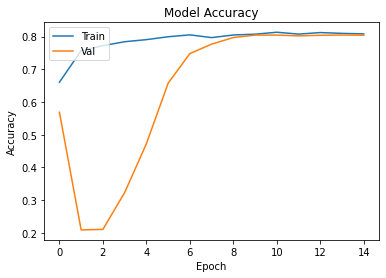

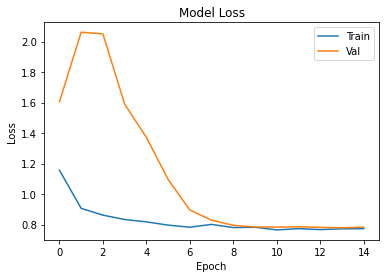

In [24]:
plot_acc(history)
plot_loss(history)

In [25]:
score = model.evaluate([x1_test[:len(x1_test)//2],x2_test[:len(x1_test)//2]], y_test[:len(x1_test)//2], verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.7643014192581177
Test accuracy: 0.8125483989715576


In [26]:
# # Para pasar la segmentacion a imagen
y_pred = model.predict([x1_test[:len(x1_test)//10],x2_test[:len(x1_test)//10]])
y_classes = [np.argmax(y_test[:len(x1_test)//10], axis=-1) for y in y_pred]
label = [np.argmax(y[:len(x1_test)//10], axis=-1) for y in y_test]

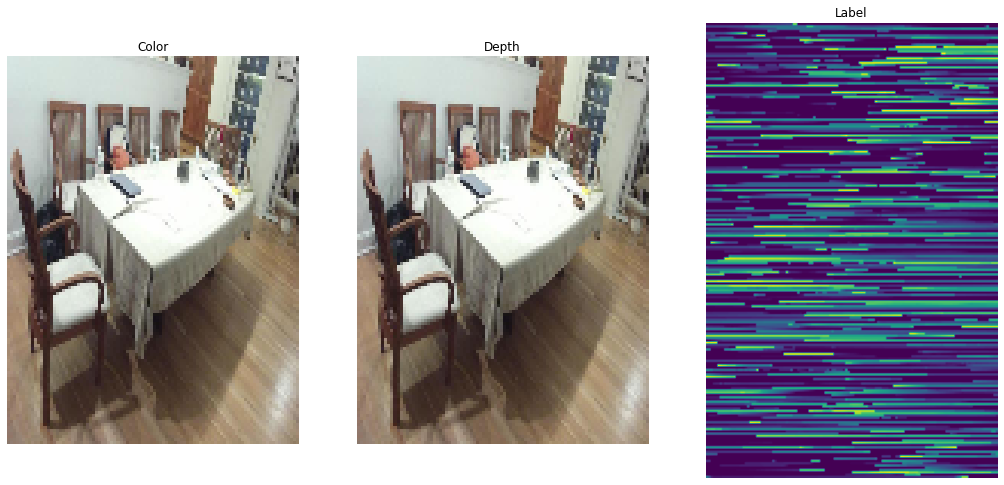

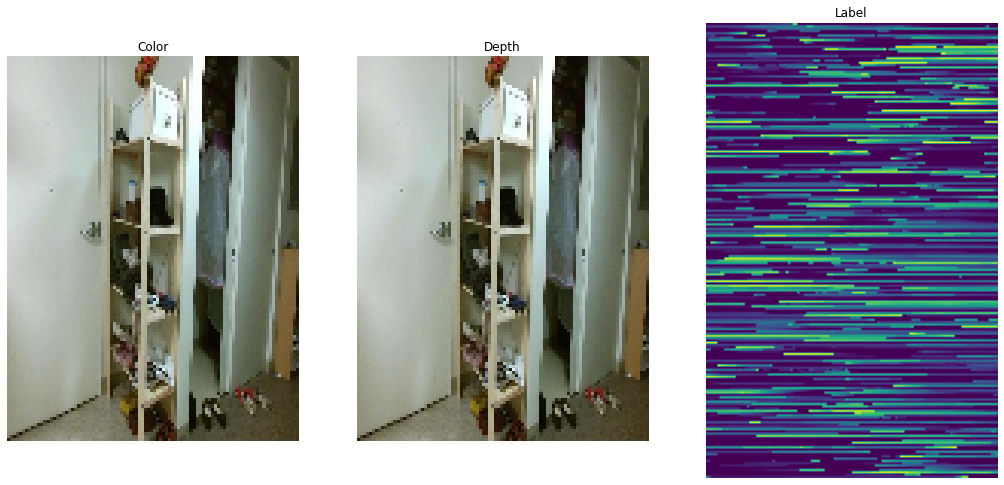

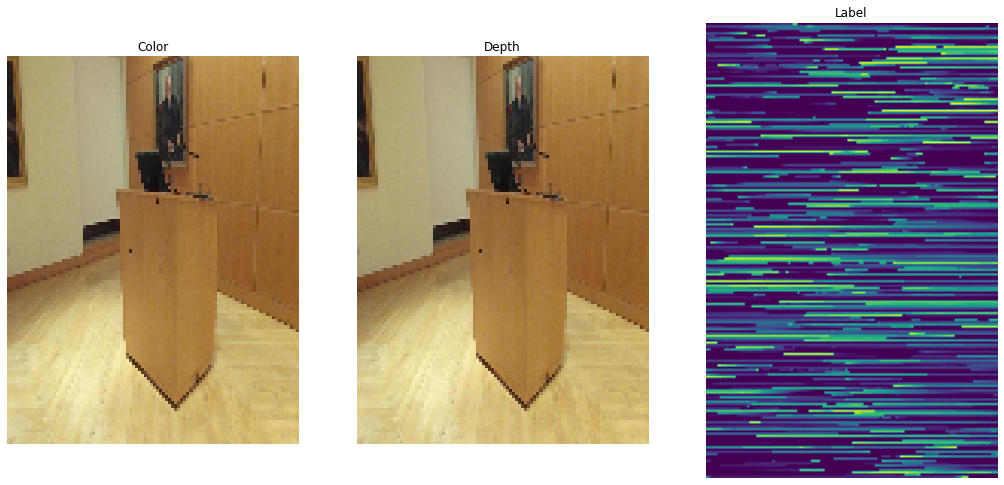

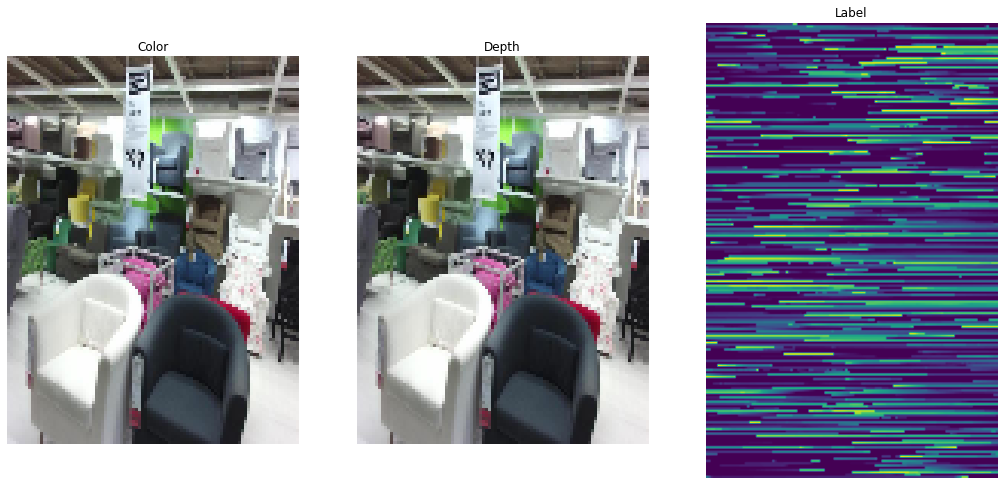

In [27]:
for number in range(4):
    fig = plt.figure("Labeled Dataset Sample", figsize=(24, 10))
    ax = fig.add_subplot(1, 4, 1)
    plot_color(ax, x1_train[number])

    ax = fig.add_subplot(1, 4, 2)
    plot_depth(ax, x2_train[number])

    ax = fig.add_subplot(1, 4, 3)
    plot_label(ax, np.argmax(y_train[number],axis=-1))
    
    ax = fig.add_subplot(1, 4, 3)
    plot_label(ax, np.argmax(y_classes[number],axis=-1))

    plt.show()

# Fine tunning

In [ ]:
# release all layers for training
# set all layers trainable and recompile model
for layer in model.layers:
    layer.trainable=True 

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.1e-7, amsgrad=True, name="Adam")

model.compile(optimizer="Adam", loss='categorical_crossentropy', 
              metrics=[dice_coef, 
                       'accuracy', 
                       true_positive_rate, 
                       iou_score
                      ])
# continue training
history = model.fit(train, epochs=100, verbose=1, validation_data=validation, callbacks=callbacks_list)

In [ ]:
score = model.evaluate([x1_test,x2_test], y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

In [ ]:
tf.math.confusion_matrix(label, y_classes)